In [1]:
import os, sys
from glob import glob
from pathlib import Path
import random 

import nibabel as nb
import matplotlib.pyplot as plt
import torch
from torchvision.models import resnet50
import torch.nn as nn
import numpy as np
from sklearn.manifold import TSNE


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from torchvision.utils import make_grid

In [4]:
def imshow_helper(arr, start_idx:int, thick_slices:int=8):
    assert arr.ndim ==3, "array should be 3D array"
    new_tensor = torch.from_numpy(arr[start_idx*thick_slices:start_idx*thick_slices+thick_slices])[None].permute(1,0,2,3)
    grid = make_grid(new_tensor,nrow=2)
    plt.imshow(norm(grid.permute(1,2,0)),cmap='gray')
    plt.axis('off')

In [38]:
def scatter_help(embedding, title:str="", **kwargs):
    cmap = mpl.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (.5, .5, .5, 1.0)

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    bounds = np.linspace(1, 28, 28)
    norm_c = mpl.colors.BoundaryNorm(bounds, cmap.N)
    tag = np.linspace(1,28,embedding.shape[0])
    plt.scatter(embedding[:,0], embedding[:,1],c=tag,cmap=cmap, norm=norm_c) if not "marker" in kwargs else plt.scatter(embedding[:,0], embedding[:,1], marker=kwargs["marker"],c=tag,cmap=cmap, norm=norm_c)
    plt.colorbar()
    plt.title(title)
    if all(k in kwargs for k in ["ymin", "ymax"]): plt.ylim(kwargs["ymin"], kwargs["ymax"])
    if all(k in kwargs for k in ["xmin", "xmax"]): plt.xlim(kwargs["xmin"], kwargs["xmax"])

In [6]:
sys.path.append("../")
from utils.load_ckpt import *

In [7]:
in_channel:int = 1 # input channel 

In [8]:
#ckpt = load_ckpt("../v4_epoch=892-step=12658275.ckpt")
ckpt = load_ckpt("../results/pretrained_resnet50/v1_epoch=372-step=5287275.ckpt")
try:
    m = resnet50(weights=None)
except:
    m = resnet50(pretrained=False)

if hasattr(m, "conv1"): m.conv1 = nn.Conv2d(in_channel, 64, kernel_size=7, stride=2, padding=3, bias=False) 

/home/rawangq1/git_wq/SSL_veronika/notebooks/../utils/load_ckpt.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_file = torch.load(ckpt_name, map_location=device)


In [9]:
update_dict_keys(ckpt, m.state_dict());

In [10]:
nii = nb.load("/mnt/qdata/share/raecker1/ukbdata_70k/abdominal_MRI/processed/2175093/wat.nii.gz").get_fdata() # in-sample data
sim = nb.load("/mnt/qdata/share/rawangq1/ukbdata_70k/abdominal_MRI/sim/2175093_wat.nii.gz").get_fdata() # in-sampled data [sim]

In [11]:
device = torch.device("cuda:0")

In [12]:
print(torch.version.cuda)

torch._C._cuda_init()

12.1


In [13]:
print(torch.__path__)

['/home/rawangq1/git_wq/SSL_veronika/.venv/lib/python3.10/site-packages/torch']


In [17]:
def get_featuremap(arr, feature_dim:int=1_000):
    """
    USAGE:
        apply 2D slice-wise (indexed by the 1st dim) inference to model
    arr: 3D array of MRI;
    feature_dim: num of dim from feature extractor's output;
    """
    feature_mat = np.empty((arr.shape[0], feature_dim),dtype=np.float32)
    for i in range(arr.shape[0]):
        arr_t = torch.Tensor(arr[i][None,None]).to(device) # [1,1,i,H,W]

        o = m.to(device)(arr_t)
        feature_mat[i,:] = o.detach().cpu().numpy()
    return feature_mat

## Init TSNE

In [13]:
tsne = TSNE()

## UKB dataset

In [14]:
norm = lambda x: (x-x.min())/(x.max() - x.min())

In [15]:
test = nb.load("/mnt/qdata/share/raecker1/data/UKB/processed/1927127_2.nii.gz").get_fdata() # [182, 218, 182] unseed data

In [18]:
feature_test = get_featuremap(test)

In [19]:
embedding_test = tsne.fit_transform(feature_test)

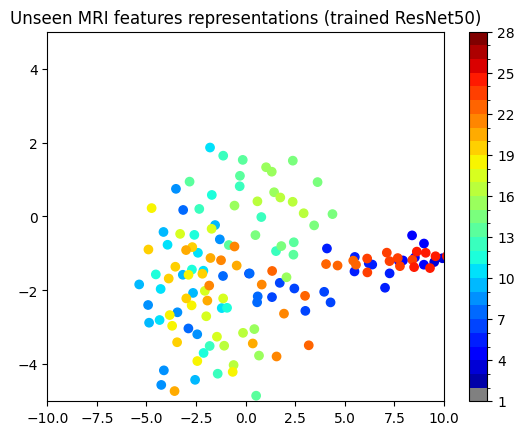

In [35]:
# remove outlier
scatter_help(embedding_test, title="Unseen MRI features representations (trained ResNet50)", ymin=-5,ymax=5, xmin=-10,xmax=10)

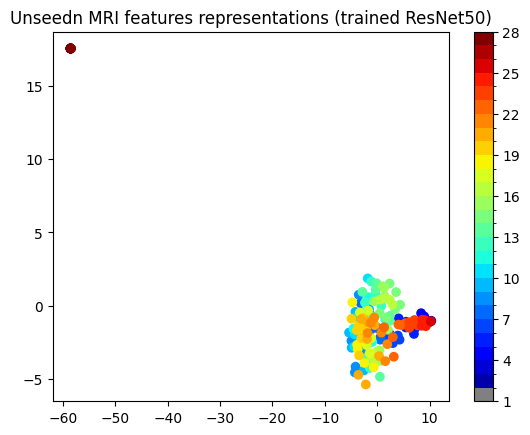

In [20]:
scatter_help(embedding_test, title="Unseedn MRI features representations (trained ResNet50)")

## Explore latent manifolds

In [21]:
feature_train = get_featuremap(norm(nii))
feature_train_sim = get_featuremap(norm(sim))

In [22]:
embedding_train = tsne.fit_transform(feature_train)
embedding_train_sim = tsne.fit_transform(feature_train_sim)

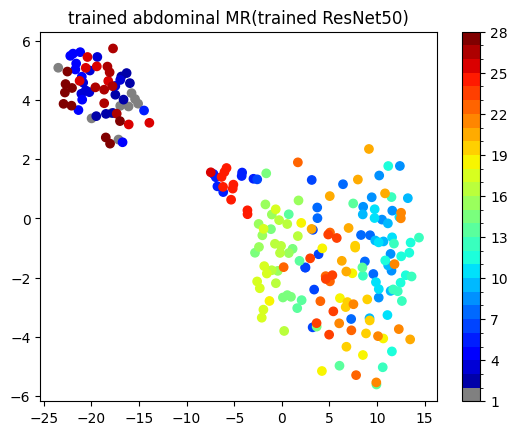

In [31]:
scatter_help(embedding_train, title="trained abdominal MR(trained ResNet50)") # by v1

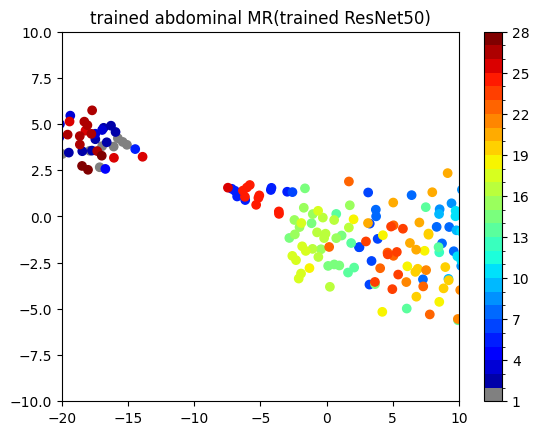

In [28]:
scatter_help(embedding_train, title="trained abdominal MR(trained ResNet50)", ymin=-10,ymax=10, xmin=-20,xmax=10) # by v1

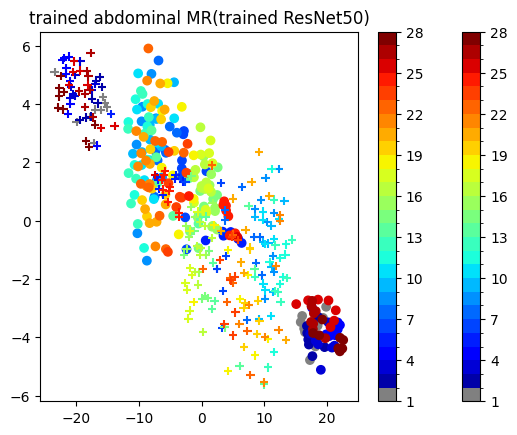

In [40]:
scatter_help(embedding_train_sim, title="unseen SIM abdomin MR(trained ResNet50)")
scatter_help(embedding_train, title="trained abdominal MR(trained ResNet50)", marker='+') # by v1

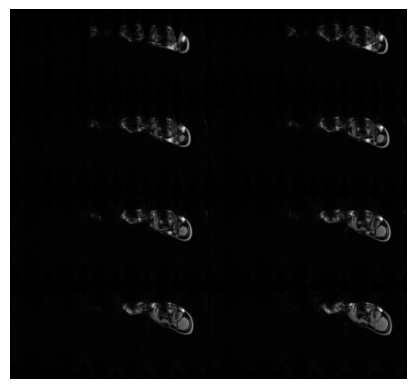

In [25]:
imshow_helper(nii, start_idx=1)# dark blue clusters

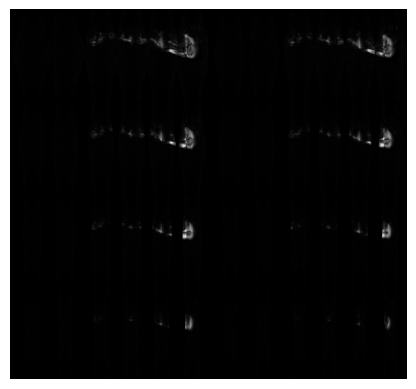

In [26]:
imshow_helper(nii, start_idx=27) # dark red clusters

In [ ]:
imshow_helper(nii, start_idx=15) # light green clusters

## Simulated motion 

In [ ]:
sim = nb.load("/mnt/qdata/share/rawangq1/ukbdata_70k/abdominal_MRI/processed/sim/2175093_wat.nii.gz").get_fdata() # []

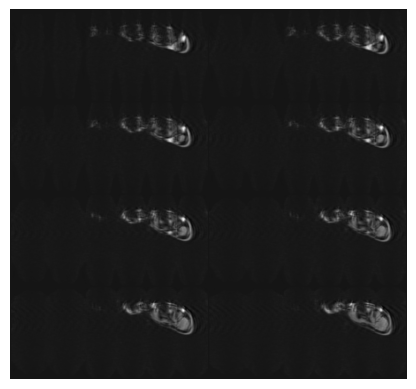

In [197]:
imshow_helper(sim[0], start_idx=1)# dark blue clusters

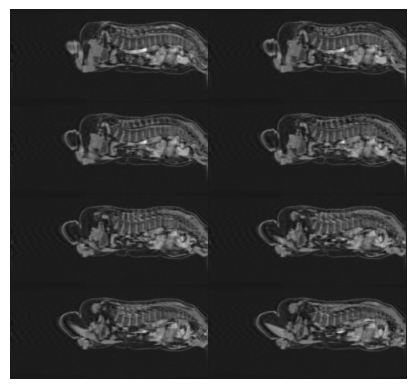

In [198]:
imshow_helper(sim[0], start_idx=15) # light green clusters

## Motivations
- [ ] How to guide existing vision encoder to perform on zero-shot data, e.g. brain MRI or simulated 

In [102]:
tag = np.linspace(1,28,224)

In [119]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200, random_state=42, algorithm='arpack')
x = svd.fit_transform(nii.reshape(224,-1))

In [120]:
tsne_raw = TSNE(perplexity=30)

In [121]:
embedding_raw = tsne_raw.fit_transform(x)

In [109]:
embedding_raw = tsne_raw.fit_transform(nii.reshape(224,-1))

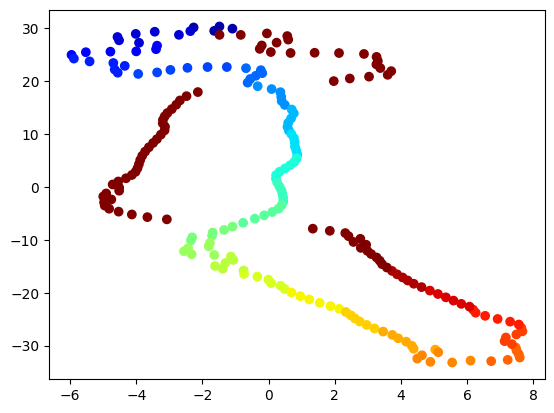

In [122]:
plt.scatter(embedding_raw[:,0], embedding_raw[:,1],c=tag, cmap=cmap, norm=norm)